In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create two Karate Club graphs
G0 = nx.karate_club_graph()
G1 = nx.karate_club_graph()

# Get the union of the two graphs
G = nx.union(G0, G1, rename=("0-", "1-"))

# Remove labels of all nodes

# Draw the union graph
#nx.draw(G, with_labels=True)
#plt.show()

Subgraph 1
Number of nodes: 34
Number of edges: 78

Subgraph 2
Number of nodes: 34
Number of edges: 78



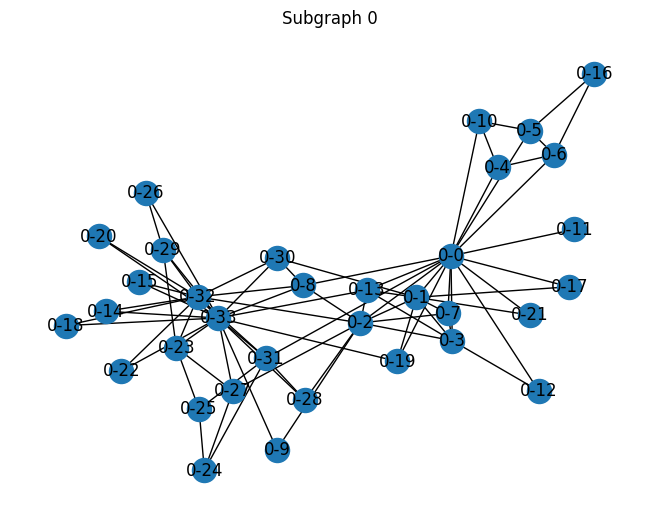

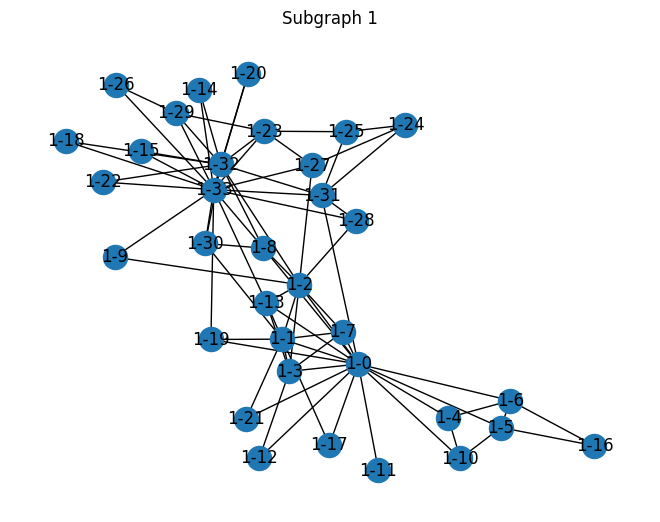

In [2]:
import matplotlib.pyplot as plt

# Get the connected components
components = nx.connected_components(G)

# Create a list to store the subgraphs
subgraphs = []

# Create a subgraph for each component
for component in components:
    subgraph = G.subgraph(component)
    subgraphs.append(subgraph)

# Print the number of nodes and edges in each subgraph
for i, subgraph in enumerate(subgraphs):
    print("Subgraph", i+1)
    print("Number of nodes:", subgraph.number_of_nodes())
    print("Number of edges:", subgraph.number_of_edges())
    print()

# Draw each subgraph separately
for i, subgraph in enumerate(subgraphs):
    plt.figure()
    nx.draw(subgraph, with_labels=True)
    plt.title("Subgraph " + str(i))

plt.show()


In [3]:
### 利用 InfoMap 算法进行社群识别
# 输出类型为一个 list

# Convert the NetworkX graph to an igraph graph
import igraph as ig
iG0 = ig.Graph.from_networkx(subgraphs[0])

# Perform Infomap clustering using igraph, and get the membership as a list
infomap_membership0 = iG0.community_infomap().membership # 类型为 list
print(f"Infomap algorithm gives {max(infomap_membership0)+1} communities.")

Infomap algorithm gives 3 communities.


/tmp/ipykernel_58382/3071498677.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw_networkx_nodes(s0, pos, node_size=40, cmap=matplotlib.cm.get_cmap('gist_rainbow'),


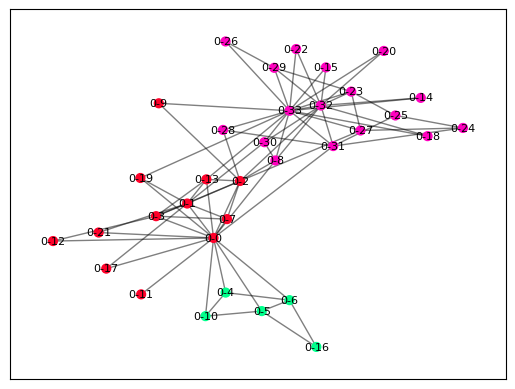

In [4]:
import matplotlib

### Create the induced subgraph
s0 = subgraphs[0]

pos = nx.spring_layout(s0)

# Get the positions for the nodes in the subgraph
pos = nx.spring_layout(s0)

# Draw nodes with colors based on community membership
nx.draw_networkx_nodes(s0, pos, node_size=40, cmap=matplotlib.cm.get_cmap('gist_rainbow'),
                       node_color=list(infomap_membership0))
nx.draw_networkx_labels(s0, pos, font_size=8, font_color='black')
# Draw edges
nx.draw_networkx_edges(s0, pos, alpha=0.5)

# Show the plot
plt.show()

In [5]:
iG1 = ig.Graph.from_networkx(subgraphs[1])

# Perform Infomap clustering using igraph, and get the membership as a list
infomap_membership1 = iG1.community_infomap().membership # 类型为 list
print(f"Infomap algorithm gives {max(infomap_membership1)+1} communities.")

Infomap algorithm gives 3 communities.


/tmp/ipykernel_58382/3850984631.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw_networkx_nodes(s1, pos, node_size=40, cmap=matplotlib.cm.get_cmap('gist_rainbow'),


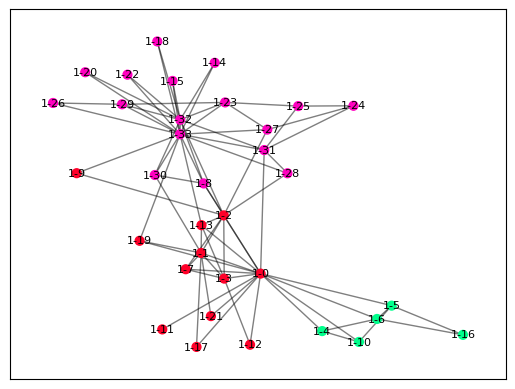

In [6]:
import matplotlib

### Create the induced subgraph
s1 = subgraphs[1]

pos = nx.spring_layout(s1)

# Get the positions for the nodes in the subgraph
pos = nx.spring_layout(s1)

# Draw nodes with colors based on community membership
nx.draw_networkx_nodes(s1, pos, node_size=40, cmap=matplotlib.cm.get_cmap('gist_rainbow'),
                       node_color=list(infomap_membership1))
nx.draw_networkx_labels(s1, pos, font_size=8, font_color='black')
# Draw edges
nx.draw_networkx_edges(s1, pos, alpha=0.5)

# Show the plot
plt.show()

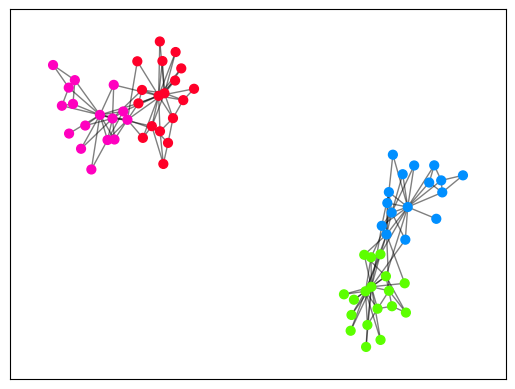

In [14]:
import matplotlib
from community import community_louvain

partition = community_louvain.best_partition(G)

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G,
                      pos,
                      partition.keys(),
                      node_size=40,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=list(partition.values())
                      )
nx.draw_networkx_edges(G, pos, alpha=0.5)

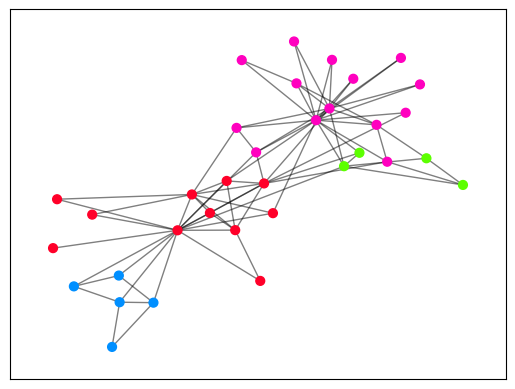

In [8]:
partition0 = community_louvain.best_partition(s0)
pos = nx.spring_layout(s0);

nx.draw_networkx_nodes(s0,
                      pos,
                      partition0.keys(),
                      node_size=40,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=list(partition0.values())
                      )
nx.draw_networkx_edges(s0, pos, alpha=0.5)

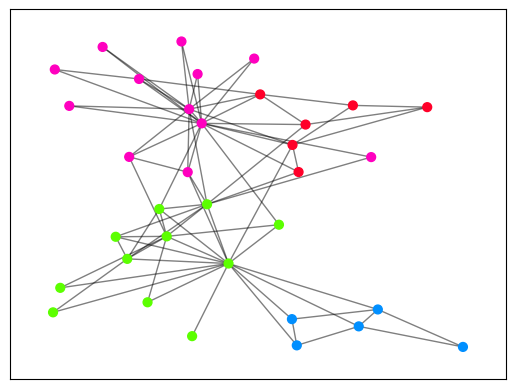

In [9]:
partition1 = community_louvain.best_partition(s1)
pos = nx.spring_layout(s1);

nx.draw_networkx_nodes(s1,
                      pos,
                      partition1.keys(),
                      node_size=40,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=list(partition1.values())
                      )
nx.draw_networkx_edges(s1, pos, alpha=0.5)

In [10]:
from auxpack.evaluate_clustering import NMI

### 使用范例
par = {**partition0, **partition1}
print(NMI(partition, par))

0.5368375804324365
0.5368375804324365


In [19]:
### 2 Laplacian 方法
from gem.embedding.lap import LaplacianEigenmaps
lap_model = LaplacianEigenmaps(d=20)

lap_embd = lap_model.learn_embedding(graph=s0, is_weighted=True, no_python=True)

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [16]:
### 聚类算法 输出NMI及 ECSim

from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors

from pyspark.ml.clustering import KMeans

from sklearn.metrics import normalized_mutual_info_score
import clusim.sim as sim
from clusim.clustering import Clustering

def evaluate_embedding(intr_list, evala): 
# 输入参数 的两个 intr 为内蕴聚类
# eval 的类型为向量 表示嵌入向量
    return_val = [] # 首先准备好返回值 
    ## 首先做 K Mean
    K = 8
    # Create a Spark DataFrame from the points
    # from pyspark.sql import SparkSession
    # from pyspark.ml.linalg import Vectors

    evala_spark = SparkSession.builder.getOrCreate()

    evala_vec = [Vectors.dense(row) for row in evala]
    
    evala_prep = SparkSession.builder.getOrCreate().\
                            createDataFrame([(vector,) for vector in evala_vec], ["embd"])

    # from pyspark.ml.clustering import KMeans

    # Create and fit the KMeans model
    euclid_kmeans = KMeans(k=K, featuresCol="embd")
    cosine_kmeans = KMeans(k=K, featuresCol="embd", distanceMeasure="cosine")
    evala_euclid_model = euclid_kmeans.fit(evala_prep)
    evala_cosine_model = cosine_kmeans.fit(evala_prep)


    # Add the cluster assignment to the DataFrame
    evala_euclid = evala_euclid_model.transform(evala_prep)
    evala_cosine = evala_cosine_model.transform(evala_prep)


    # Extract the cluster assignment and convert it to a list
    evala_euclid_membership = evala_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
    evala_cosine_membership = evala_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()

    ## 然后开始与内蕴聚类进行比较
    return_val.append(normalized_mutual_info_score(evala_euclid_membership, intr_list))
    return_val.append(normalized_mutual_info_score(evala_cosine_membership, intr_list))
    
    return return_val

In [20]:
evaluate_embedding(list(partition0.values()), lap_embd)

[0.41165334354915345, 0.45957001247047435]